In [44]:
import sys
sys.path.append("/home/zoker/quict/")

import collections
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import tqdm
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn as sns

import torch.utils.tensorboard

from QuICT.algorithm.quantum_machine_learning.ansatz_library import QNNLayer
from QuICT.algorithm.quantum_machine_learning.utils.encoding import *
from QuICT.algorithm.quantum_machine_learning.utils.ml_utils import *
from QuICT.algorithm.quantum_machine_learning.model.QNN import QuantumNet
from QuICT.simulation.state_vector import ConstantStateVectorSimulator


In [2]:
train_data = datasets.MNIST(root="./data/", train=True, download=True)
test_data = datasets.MNIST(root="./data/", train=False, download=True)
train_X = train_data.data
train_Y = train_data.targets
test_X = test_data.data
test_Y = test_data.targets
print("Training examples: ", len(train_Y))
print("Testing examples: ", len(test_Y))

Training examples:  60000
Testing examples:  10000


In [3]:
def filter_targets(X, Y, class0=3, class1=6):
    idx = (Y == class0) | (Y == class1)
    X, Y = (X[idx], Y[idx])
    Y = Y == class1
    return X, Y

In [4]:
train_X, train_Y = filter_targets(train_X, train_Y)
test_X, test_Y = filter_targets(test_X, test_Y)
print("Filtered training examples: ", len(train_Y))
print("Filtered testing examples: ", len(test_Y))

Filtered training examples:  12049
Filtered testing examples:  1968


Label:  tensor(False)


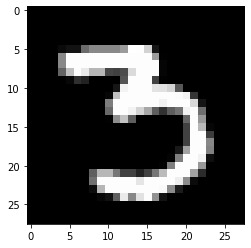

In [5]:
print("Label: ", train_Y[200])
plt.imshow(train_X[200], cmap="gray")

In [6]:
def downscale(X, resize):
    transform = transforms.Resize(size=resize)
    X = transform(X) / 255.0
    return X

In [7]:
resized_train_X = downscale(train_X, (4, 4))
resized_test_X = downscale(test_X, (4, 4))

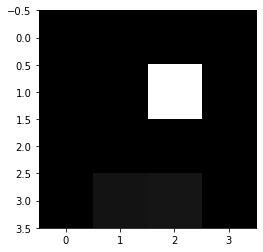

In [8]:
plt.imshow(resized_train_X[200], cmap="gray")

In [9]:
def remove_conflict(X, Y, resize):
    x_dict = collections.defaultdict(set)
    for x, y in zip(X, Y):
        x_dict[tuple(x.numpy().flatten())].add(y.item())
    X_rmcon = []
    Y_rmcon = []
    for x in x_dict.keys():
        if len(x_dict[x]) == 1:
            X_rmcon.append(np.array(x).reshape(resize))
            Y_rmcon.append(list(x_dict[x])[0])
    X = torch.from_numpy(np.array(X_rmcon))
    Y = torch.from_numpy(np.array(Y_rmcon))
    return X, Y

In [10]:
nocon_train_X, nocon_train_Y = remove_conflict(resized_train_X, train_Y, (4, 4))
nocon_test_X, nocon_test_Y = remove_conflict(resized_test_X, test_Y, (4, 4))
print("Remaining training examples: ", len(nocon_train_Y))
print("Remaining testing examples: ", len(nocon_test_Y))

Remaining training examples:  10338
Remaining testing examples:  1793


In [11]:
def binary_img(X, threshold):
    X = (X > threshold).type(torch.int)
    return X

In [12]:
threshold = 0.5
bin_train_X = binary_img(nocon_train_X, threshold)
bin_test_X = binary_img(nocon_test_X, threshold)

In [13]:
_train_X, _train_Y = remove_conflict(binary_img(resized_train_X, threshold), train_Y, (4, 4))
_test_X, _test_Y = remove_conflict(binary_img(resized_test_X, threshold), test_Y, (4, 4))
print("Remaining training examples: ", len(_train_Y))
print("Remaining testing examples: ", len(_test_Y))

Remaining training examples:  148
Remaining testing examples:  93


In [14]:
device = torch.device("cuda:0")

train_X = bin_train_X.to(device)
train_Y = nocon_train_Y.to(device)
test_X = bin_test_X.to(device)
test_Y = nocon_test_Y.to(device)

2023-01-09 19:35:05 | circuit | INFO | Initial Quantum Circuit circuit_a9ad3d58901111eda0ae8d6e060af9f8 with 4 qubits.


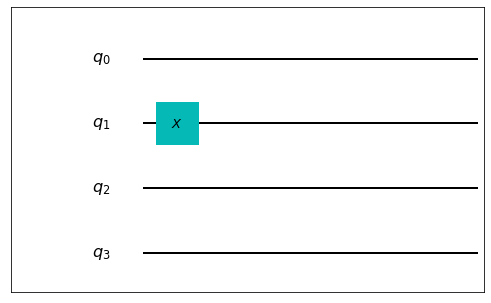

In [15]:
img = torch.tensor([[0, 1], [0, 0]]).to(device)
data_qubits = 4
qe = Qubit(data_qubits, device)
qe.encoding(img, circuit=True)
qe.circuit.draw()

In [16]:
def qubit_encoding(X, device):
    new_X = []
    n_qubits = X[0].shape[0] * X[0].shape[1]
    qe = Qubit(n_qubits, device)
    for x in X:
        qe.encoding(x)
        new_X.append(qe.ansatz)
    return new_X

In [17]:
ansatz_train_X = qubit_encoding(train_X, device)
ansatz_test_X = qubit_encoding(test_X, device)

2023-01-09 19:35:11 | circuit | INFO | Initial Quantum Circuit circuit_ad714ccc901111eda0ae8d6e060af9f8 with 5 qubits.


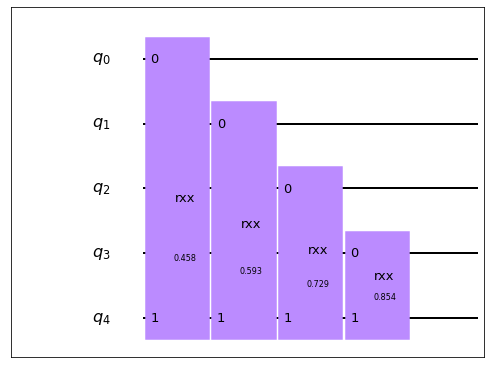

In [18]:
pqc = QNNLayer(list(range(4)), 4, device=device)
params = nn.Parameter(torch.rand(1, 4, device=device), requires_grad=True)
model_circuit = pqc.circuit_layer(["XX"], params)
model_circuit.draw()

In [19]:
data_qubits = list(range(16))
readout_qubit = 16
pqc = QNNLayer(data_qubits, readout_qubit, device=device)
layers = ["XX", "ZZ"]
params = nn.Parameter(torch.rand(2, 16, device=device), requires_grad=True)
model_ansatz = pqc(layers, params)

In [40]:
EPOCH = 3       # 训练总轮数
BATCH_SIZE = 32 # 一次迭代使用的样本数
LR = 0.001      # 梯度下降的学习率
SEED = 17       # 随机数种子

set_seed(SEED)  # 设置全局随机种子

In [21]:
train_dataset = data.TensorDataset(train_X, train_Y)
test_dataset = data.TensorDataset(test_X, test_Y)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [22]:
net = QuantumNet(16, ["XX", "ZZ"], encoding="qubit", device=device)
optim = torch.optim.Adam([dict(params=net.parameters(), lr=LR)])

In [23]:
def loss_func(y_true, y_pred):
    y_true = 2 * y_true.type(torch.float32) - 1.0
    y_pred = 2 * y_pred - 1.0
    loss = torch.clamp(1 - y_pred * y_true, min=0.0)
    correct = torch.where(y_true * y_pred > 0)[0].shape[0]
    return torch.mean(loss), correct

In [26]:
tb = torch.utils.tensorboard.SummaryWriter("/home/zoker/quict/QNN_MNIST/logs")

# train epoch
for ep in range(EPOCH):
    net.train()
    loader = tqdm.tqdm(
        train_loader, desc="Training epoch {}".format(ep + 1), leave=True
    )
    # train iteration
    for it, (x_train, y_train) in enumerate(loader):
        optim.zero_grad()
        y_pred = net(x_train)
        loss, correct = loss_func(y_train, y_pred)
        accuracy = correct / len(y_train)
        loss.backward()
        optim.step()
        loader.set_postfix(
            it=it,
            loss="{:.3f}".format(loss),
            accuracy="{:.3f}".format(accuracy),
        )
        tb.add_scalar("train/loss", loss, ep * len(loader) + it)
        tb.add_scalar("train/accuracy", accuracy, ep * len(loader) + it)
        # Save checkpoint
        latest = (ep + 1) == EPOCH and (it + 1) == len(loader)
        if ((it + 1) % 30 == 0 or latest):
            save_checkpoint(
                net, optim, "/home/zoker/quict/QNN_MNIST", ep, it + 1, latest
            )

    # Validation
    net.eval()
    loader_val = tqdm.tqdm(
        test_loader, desc="Validating epoch {}".format(ep + 1), leave=True
    )
    loss_val_list = []
    total_correct = 0
    for it, (x_test, y_test) in enumerate(loader_val):
        y_pred = net(x_test)
        loss_val, correct = loss_func(y_test, y_pred)
        loss_val_list.append(loss_val.cpu().detach().numpy())
        total_correct += correct
        accuracy_val = correct / len(y_test)
        loader_val.set_postfix(
            it=it,
            loss="{:.3f}".format(loss_val),
            accuracy="{:.3f}".format(accuracy_val),
        )
    avg_loss = np.mean(loss_val_list)
    avg_acc = total_correct / (len(loader_val) * BATCH_SIZE)
    tb.add_scalar("validation/loss", avg_loss, ep)
    tb.add_scalar("validation/accuracy", avg_acc, ep)
    print("Validation Average Loss: {}, Accuracy: {}".format(avg_loss, avg_acc))


Validating epoch 1: 100%|██████████| 56/56 [05:47<00:00,  6.20s/it, accuracy=0.781, it=55, loss=0.611]


Validation average Loss: 0.5802477598190308, Accuracy: 0.8337053571428571


Validating epoch 2: 100%|██████████| 56/56 [05:31<00:00,  5.91s/it, accuracy=0.781, it=55, loss=0.518]


Validation average Loss: 0.43216872215270996, Accuracy: 0.8325892857142857


Validating epoch 3: 100%|██████████| 56/56 [05:54<00:00,  6.33s/it, accuracy=0.844, it=55, loss=0.426]

Validation average Loss: 0.39801928400993347, Accuracy: 0.8348214285714286


In [48]:
# Restore checkpoint
model_path = "/home/zoker/quict/QuICT/algorithm/quantum_machine_learning/trained_models/QNN_MNIST.ckpt"
restore_checkpoint(net, optim, model_path, device, resume=True)
net.eval()
loader = tqdm.tqdm(test_loader, desc="Testing", leave=True)
total_correct = 0

# Start testing
for it, (x_test, y_test) in enumerate(loader):
    y_pred = net(x_test)
    loss, correct = loss_func(y_test, y_pred)
    total_correct += correct
    loader.set_postfix(
        it=it,
        loss="{:.3f}".format(loss),
        correct="{0}".format(bool(correct)),
    )
qnn_avg_acc = total_correct / (len(loader) * BATCH_SIZE)
print("Testing Average Accuracy: {}".format(qnn_avg_acc))

Testing: 100%|██████████| 56/56 [05:50<00:00,  6.26s/it, correct=True, it=55, loss=0.370]

Testing Average Accuracy: 0.8348214285714286


In [49]:
class ClassicalNet(nn.Module):
    def __init__(self):
        super(ClassicalNet, self).__init__()
        self.fc1 = torch.nn.Sequential(torch.nn.Linear(16, 4), torch.nn.ReLU())
        self.fc2 = torch.nn.Linear(4, 1)

    def forward(self, x):
        x = x.type(torch.float)
        x = x.view(32, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.flatten()
        return x

In [50]:
classical_net = ClassicalNet().to(device)
classical_optim = torch.optim.Adam([dict(params=classical_net.parameters(), lr=LR)])
EPOCH = 1

# train epoch
for ep in range(EPOCH):
    classical_net.train()
    loader = tqdm.tqdm(
        train_loader, desc="Training epoch {}".format(ep + 1), leave=True
    )
    # train iteration
    for it, (x_train, y_train) in enumerate(loader):
        correct = 0
        classical_optim.zero_grad()
        y_pred = classical_net(x_train)
        y_train = 2 * y_train - 1.0
        loss, correct = loss_func(y_train, y_pred)
        accuracy = correct / len(y_train)
        loss.backward()
        classical_optim.step()
        loader.set_postfix(
            it=it,
            loss="{:.3f}".format(loss),
            accuracy="{:.3f}".format(accuracy),
        )

    # Validation
    classical_net.eval()
    loader_val = tqdm.tqdm(
        test_loader, desc="Validating epoch {}".format(ep + 1), leave=True
    )
    loss_val_list = []
    total_correct = 0
    for it, (x_test, y_test) in enumerate(loader_val):
        correct = 0
        y_pred = classical_net(x_train)
        y_test = 2 * y_train - 1.0
        loss_val, correct = loss_func(y_train, y_pred)
        loss_val_list.append(loss_val.cpu().detach().numpy())
        total_correct += correct
        accuracy_val = correct / len(y_test)
        loader_val.set_postfix(
            it=it,
            loss="{:.3f}".format(loss_val),
            accuracy="{:.3f}".format(accuracy_val),
        )
    avg_loss = np.mean(loss_val_list)
    classical_avg_acc = total_correct / (len(loader_val) * BATCH_SIZE)
    print("Validation Average Loss: {}, Accuracy: {}".format(avg_loss, classical_avg_acc))


Validating epoch 1: 100%|██████████| 56/56 [00:00<00:00, 1146.57it/s, accuracy=0.906, it=55, loss=0.414]

Validation Average Loss: 0.41374948620796204, Accuracy: 0.90625


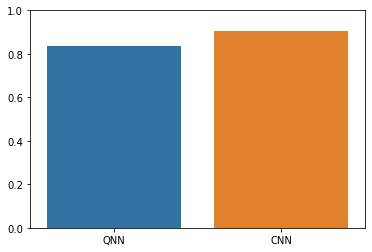

In [52]:
ax = sns.barplot(x=["QNN", "CNN"], y=[qnn_avg_acc, classical_avg_acc])
ax.set_yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])